<a href="https://colab.research.google.com/github/Sudhandar/Adding-relevant-emoticons/blob/master/bert_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 9.1MB/s 
     |████████████████████████████████| 92kB 12.3MB/s 


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P4'

In [5]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv
Saving test.csv to test.csv


In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
train.head(5)

,sentence,label
0,never talk to me again,3
1,I am proud of your achievements,2
2,It is the worst day in my life,3
3,Miss you so much,0
4,food is life,4


In [0]:
sentences = train.sentence.values
sentences = [ "[CLS] "+sentence+" [SEP]" for sentence in sentences]

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

tokenized_text = [tokenizer.tokenize(sentence) for sentence in sentences]

tokenized_text[0]

100%|██████████| 231508/231508 [00:00<00:00, 904762.77B/s]


['[CLS]', 'never', 'talk', 'to', 'me', 'again', '[SEP]']

In [0]:
max_len = 50
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_text]
input_ids = pad_sequences(input_ids,maxlen=max_len,dtype='long',padding='post',truncating='post')

In [0]:
attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [12]:
train_labels = pd.get_dummies(train['label'])
labels = train_labels.values
labels[0]

array([0, 0, 0, 1, 0], dtype=uint8)

In [35]:
train_labels = train['label']
labels = train_labels.values
labels[0]

3

In [0]:
def bert_inputs(df,maxlen):
  sentences = df.sentence.values
  sentences = ["[CLS] "+sentence+" [SEP]" for sentence in sentences]
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)
  sentences = [tokenizer.tokenize(sentence) for sentence in sentences]
  sentence_ids = [tokenizer.convert_tokens_to_ids(sentence) for sentence in sentences]
  sentence_ids = pad_sequences(sentence_ids,maxlen=maxlen,dtype='long',padding='post',truncating='post')
  attention_masks = []
  for sentence in sentence_ids:
    seq_mask = [float(i>0) for i in sentence]
    attention_masks.append(seq_mask)
  #lables = pd.get_dummies(df['label'])
  #labels = lables.values
  labels = df['label'].values

  return sentence_ids,labels,attention_masks


In [0]:
test_inputs, test_labels, test_masks = bert_inputs(test,50)

In [0]:
train_inputs = torch.tensor(input_ids)
train_labels = torch.tensor(labels)
test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels)
train_masks = torch.tensor(attention_masks)
test_masks = torch.tensor(test_masks)

In [0]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [60]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 5 )
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [0]:
param_optimizer = list(model.named_parameters())

In [64]:
optimizer = BertAdam(model.parameters(),
                  lr=2e-5,
                  warmup=.1
                )

t_total value of -1 results in schedule not being applied


In [0]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [75]:
train_loss = []
epochs = 4
for _ in trange(epochs, desc = "Epoch"):
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  for step,batch in enumerate(train_dataloader):
    b_input_ids, b_input_mask, b_labels = batch
    b_labels = b_labels.to(device)
    b_input_mask = b_input_mask.to(device)
    b_input_ids = b_input_ids.to(device)
    optimizer.zero_grad()
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss.append(loss.item()) 
    loss.backward()
    optimizer.step()
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))

Epoch:  25%|██▌       | 1/4 [00:02<00:06,  2.17s/it]

Train loss: 0.2527703642845154


Epoch:  50%|█████     | 2/4 [00:04<00:04,  2.15s/it]

Train loss: 0.08625235110521316


Epoch:  75%|███████▌  | 3/4 [00:06<00:02,  2.14s/it]

Train loss: 0.03781069070100784


Epoch: 100%|██████████| 4/4 [00:08<00:00,  2.14s/it]

Train loss: 0.022244590520858764


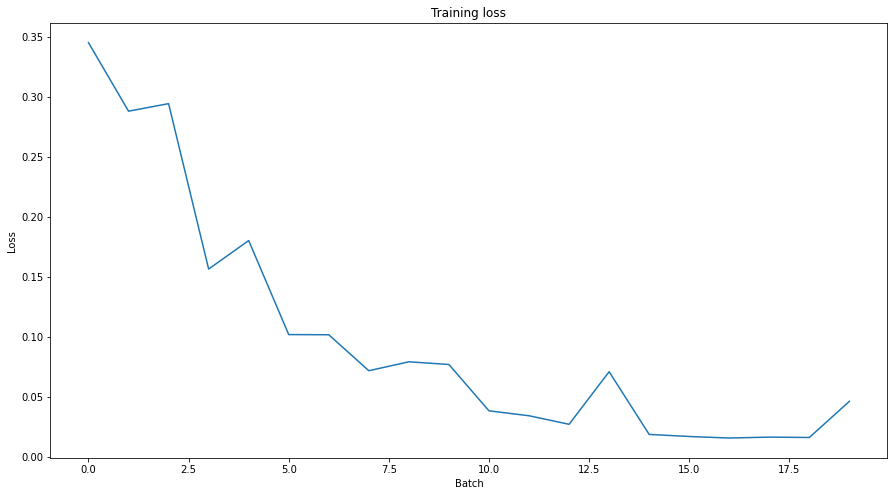

In [76]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss)
plt.show()

In [0]:
model.eval()
predictions , true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

In [78]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []
for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)
  
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))

Classification accuracy using BERT Fine Tuning: 79.43%


In [79]:
flat_predictions

array([4, 2, 0, 2, 3, 0, 2, 3, 1, 1, 2, 4, 3, 2, 3, 3, 2, 1, 2, 2, 2, 0,
       2, 2, 3, 0, 4, 2, 0, 2, 3, 2, 3, 3, 0, 2, 4, 3, 4, 2, 4, 1, 4, 2,
       1, 2, 2, 3, 3, 2, 2, 4, 0, 2, 0, 3])